# Import Modules

In [1]:
import pandas as pd
import numpy as np
import os
import cv2
import glob
import matplotlib.pyplot as plt
import warnings
import tensorflow as tf
from tensorflow.keras import backend as B
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array, ImageDataGenerator
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.callbacks import Callback

from ipynb.fs.full.utils import *

# Variables Initialization and Data Description

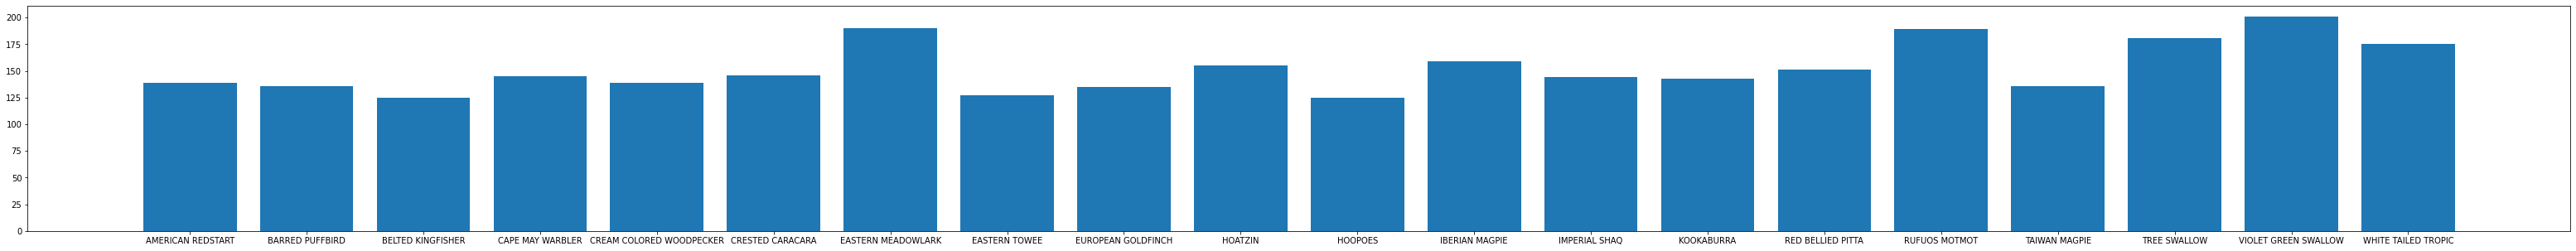

In [2]:
train_path = './dataset/20train'
test_path = './dataset/20test'
valid_path = './dataset/20valid'
nr_birds = 20

describe_data();

# Prepare Generators

Found 3041 images belonging to 20 classes.
Found 100 images belonging to 20 classes.
Found 100 images belonging to 20 classes.


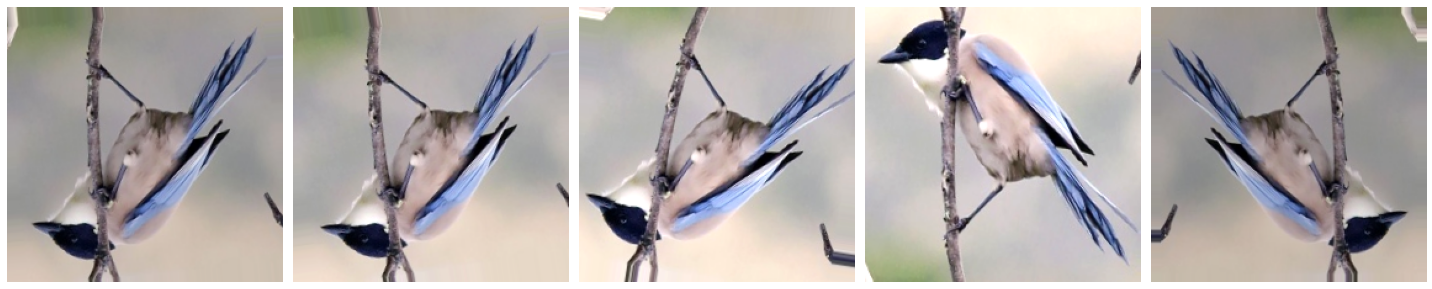

In [3]:
# Data augmentation
train_datagen = ImageDataGenerator(
  rescale=1/255,
  horizontal_flip=True,
  vertical_flip=True,
  rotation_range=15,
  zoom_range=0.1,
  brightness_range=[0.5, 1.5],
)
valid_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
  train_path,
  target_size=(224, 224),
  batch_size=64,
  color_mode='rgb',
  class_mode='categorical',
  shuffle=True
)

validation_generator = valid_datagen.flow_from_directory(
  valid_path,
  target_size=(224, 224),
  batch_size=32,
  color_mode='rgb',
  class_mode='categorical',
  shuffle=False
)

test_generator = test_datagen.flow_from_directory(
  test_path,
  target_size=(224, 224),
  batch_size=32,
  color_mode='rgb',
  class_mode='categorical',
  shuffle=False
  )

def plotImages(images_arr):
  fig, axes = plt.subplots(1, 5, figsize=(20,20))
  axes = axes.flatten()
  for img, ax in zip(images_arr, axes):
      ax.imshow(img)
      ax.axis('off')
  plt.tight_layout()
  plt.show()
    
augmented_images = [train_generator[0][0][0] for i in range(5)]
plotImages(augmented_images)

# Load pre-trained Model, Build model and Train model

In [4]:
base_mobilenet = MobileNet(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

for layer in base_mobilenet.layers:
  layer.trainable = False

# base_mobilenet.trainable = False
base_mobilenet.summary()

new_model = Sequential()
new_model.add(base_mobilenet)

new_model.add(Flatten()) 
new_model.add(Activation('relu'))
new_model.add(Dropout(0.2))
new_model.add(Dense(nr_birds)) 
new_model.add(Activation('softmax'))
new_model.summary()

new_model.compile(SGD(lr=0.001, momentum=0.9, nesterov=True), loss='categorical_crossentropy', metrics=['accuracy'])

def lr_scheduler(epoch, lr):
  if epoch < 5:
    return lr
  else:
    return lr * tf.math.exp()
  
class EarlyStoppingByLossVal(Callback):
  def __init__(self, monitor='val_loss', value=0.00001, verbose=0):
    super(Callback, self).__init__()
    self.monitor = monitor
    self.value = value
    self.verbose = verbose
      

  def on_epoch_end(self, epoch, logs={}):
    current = logs.get(self.monitor)
    if current is None:
        warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

    if current < self.value:
        if self.verbose > 0:
            print("Epoch %05d: early stopping THR" % epoch)
        self.model.stop_training = True
        
checkpointer = ModelCheckpoint(filepath='./checkpoints/mobile_net_birds.model.h5', save_best_only=True)

2022-05-08 19:18:27.214103: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-08 19:18:27.214300: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 1

/Users/shaun/miniforge3/lib/python3.9/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [5]:
SgdHistory = new_model.fit_generator(train_generator, epochs=30, validation_data=validation_generator, verbose=1, callbacks=[checkpointer, EarlyStoppingByLossVal(monitor='val_loss', value=0.001, verbose=1)])
B.clear_session()

new_model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
AdamHistory = new_model.fit_generator(train_generator, epochs=30, validation_data=validation_generator, verbose=1, callbacks=[checkpointer, EarlyStoppingByLossVal(monitor='val_loss', value=0.001, verbose=1)])

/var/folders/x0/f6tjyw_s7vqbx5gcpvt0z31w0000gn/T/ipykernel_50167/2900528882.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  SgdHistory = new_model.fit_generator(train_generator, epochs=30, validation_data=validation_generator, verbose=1, callbacks=[checkpointer, EarlyStoppingByLossVal(monitor='val_loss', value=0.001, verbose=1)])


Epoch 1/30


2022-05-08 19:18:28.356549: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-08 19:18:28.928353: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


48/48 [==============================] - ETA: 0s - loss: 2.8517 - accuracy: 0.6623

2022-05-08 19:18:49.063773: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


48/48 [==============================] - 22s 426ms/step - loss: 2.8517 - accuracy: 0.6623 - val_loss: 0.3289 - val_accuracy: 0.9300
Epoch 2/30
48/48 [==============================] - 20s 415ms/step - loss: 0.4975 - accuracy: 0.9046 - val_loss: 0.2826 - val_accuracy: 0.9300
Epoch 3/30
48/48 [==============================] - 20s 420ms/step - loss: 0.3621 - accuracy: 0.9290 - val_loss: 0.3118 - val_accuracy: 0.9500
Epoch 4/30
48/48 [==============================] - 22s 445ms/step - loss: 0.2701 - accuracy: 0.9415 - val_loss: 0.1741 - val_accuracy: 0.9700
Epoch 5/30
48/48 [==============================] - 24s 493ms/step - loss: 0.2096 - accuracy: 0.9556 - val_loss: 0.2009 - val_accuracy: 0.9600
Epoch 6/30
48/48 [==============================] - 25s 518ms/step - loss: 0.1730 - accuracy: 0.9635 - val_loss: 0.3100 - val_accuracy: 0.9500
Epoch 7/30
48/48 [==============================] - 25s 521ms/step - loss: 0.1715 - accuracy: 0.9655 - val_loss: 0.0845 - val_accuracy: 0.9600
Epoch 8/30

/Users/shaun/miniforge3/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/var/folders/x0/f6tjyw_s7vqbx5gcpvt0z31w0000gn/T/ipykernel_50167/2900528882.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  AdamHistory = new_model.fit_generator(train_generator, epochs=30, validation_data=validation_generator, verbose=1, callbacks=[checkpointer, EarlyStoppingByLossVal(monitor='val_loss', value=0.001, verbose=1)])


Epoch 1/30


2022-05-08 19:32:17.995122: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


48/48 [==============================] - ETA: 0s - loss: 0.5628 - accuracy: 0.9207

2022-05-08 19:32:52.232094: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


48/48 [==============================] - 36s 720ms/step - loss: 0.5628 - accuracy: 0.9207 - val_loss: 0.4666 - val_accuracy: 0.9400
Epoch 2/30
48/48 [==============================] - 33s 694ms/step - loss: 0.8511 - accuracy: 0.9155 - val_loss: 0.2144 - val_accuracy: 0.9600
Epoch 3/30
48/48 [==============================] - 33s 691ms/step - loss: 0.6294 - accuracy: 0.9402 - val_loss: 0.6065 - val_accuracy: 0.9500
Epoch 4/30
48/48 [==============================] - 33s 690ms/step - loss: 0.4984 - accuracy: 0.9523 - val_loss: 0.3079 - val_accuracy: 0.9600
Epoch 5/30
48/48 [==============================] - 35s 715ms/step - loss: 0.4876 - accuracy: 0.9540 - val_loss: 0.1300 - val_accuracy: 0.9500
Epoch 6/30
48/48 [==============================] - 34s 707ms/step - loss: 0.4771 - accuracy: 0.9566 - val_loss: 0.3475 - val_accuracy: 0.9600
Epoch 7/30
48/48 [==============================] - 34s 701ms/step - loss: 0.5245 - accuracy: 0.9576 - val_loss: 0.4624 - val_accuracy: 0.9600
Epoch 8/30

/var/folders/x0/f6tjyw_s7vqbx5gcpvt0z31w0000gn/T/ipykernel_50167/3009081634.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


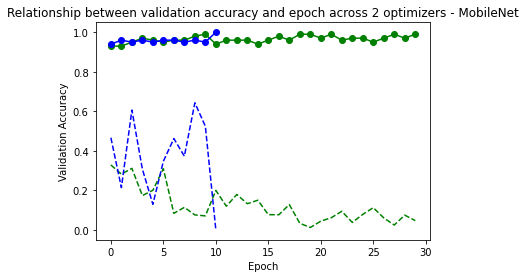

In [14]:
def plotOptimizer():
  fig = plt.figure(facecolor="w")
  plt.plot(SgdHistory.history['val_accuracy'], 'g', marker='o',)
  plt.plot(SgdHistory.history['val_loss'], 'g',  linestyle = 'dashed')
  plt.plot(AdamHistory.history['val_accuracy'], 'b', marker='o',)
  plt.plot(AdamHistory.history['val_loss'], 'b',  linestyle = 'dashed')
  
  plt.title('Relationship between validation accuracy and epoch across 2 optimizers - MobileNet')
  plt.xlabel('Epoch')
  plt.ylabel('Validation Accuracy')
  return fig

fig = plotOptimizer()
fig.show()

# Loss and Accuracy Graph

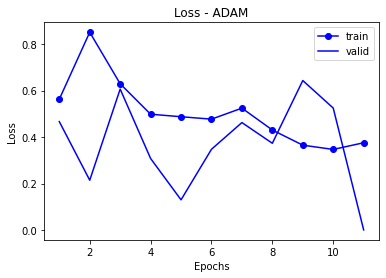

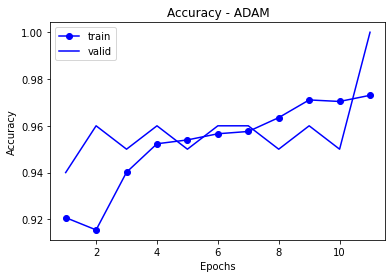

best val_acc: 1.0 epoch: 10
best val_loss: 0.0005659886519424617 epoch: 10


In [15]:
history_dict = AdamHistory.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
acc_values = history_dict["accuracy"]
val_acc_values = history_dict["val_accuracy"]
epochs = range(1, len(history_dict["accuracy"]) + 1)

plt.figure(facecolor="w")
plt.plot(epochs, loss_values, "b",marker="o", label="train")
plt.plot(epochs, val_loss_values, "b", label="valid")
plt.title("Loss - ADAM")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(facecolor="w")
plt.plot(epochs, acc_values, "b", marker="o", label="train")
plt.plot(epochs, val_acc_values, "b", label="valid")
plt.title("Accuracy - ADAM")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

import numpy as np
print("best val_acc:", np.max(val_acc_values), "epoch:", np.argmax(val_acc_values))
print("best val_loss:", np.min(val_loss_values), "epoch:", np.argmin(val_loss_values))

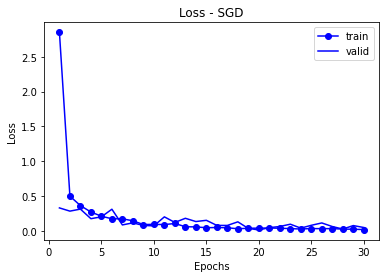

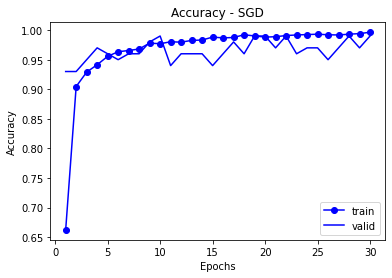

best val_acc: 0.9899999499320984 epoch: 9
best val_loss: 0.012810912914574146 epoch: 19


In [17]:
history_dict = SgdHistory.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
acc_values = history_dict["accuracy"]
val_acc_values = history_dict["val_accuracy"]
epochs = range(1, len(history_dict["accuracy"]) + 1)

plt.figure(facecolor="w")
plt.plot(epochs, loss_values, "b",marker="o", label="train")
plt.plot(epochs, val_loss_values, "b", label="valid")
plt.title("Loss - SGD")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(facecolor="w")
plt.plot(epochs, acc_values, "b", marker="o", label="train")
plt.plot(epochs, val_acc_values, "b", label="valid")
plt.title("Accuracy - SGD")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

import numpy as np
print("best val_acc:", np.max(val_acc_values), "epoch:", np.argmax(val_acc_values))
print("best val_loss:", np.min(val_loss_values), "epoch:", np.argmin(val_loss_values))

In [9]:
def plotLR(history):
    learning_rate = history.history['lr']
    epochs = range(1, len(learning_rate) + 1)
    fig = plt.figure()
    plt.plot(learning_rate[:40], history.history['val_loss'][:40])
    plt.title('Relationship between loss and learning rate')
    plt.xlabel('Learning Rate')
    plt.ylabel('Validation Loss')
    return(fig)
  
# fig = plotLR(history)
# fig.show()

# Testing

In [10]:
test_loss, test_acc = new_model.evaluate(test_generator)
print("Test Accuracy:", test_acc)

4/4 [==============================] - 1s 110ms/step - loss: 0.8226 - accuracy: 0.9700
Test Accuracy: 0.9699999690055847


# Saving Model

In [11]:
new_model.save('./models/mobile_net.h5')

## Running Predictions From Saved Model

In [12]:
def decode (predicted_arr):
  train_path = './dataset/20train'

  all_birds_cat = np.array(list(sorted(os.listdir(train_path))))
  for i, pred in enumerate(predicted_arr):
    confidence = np.round(np.max(pred) * 100, 2)
    return (all_birds_cat[np.argmax(pred)], confidence)


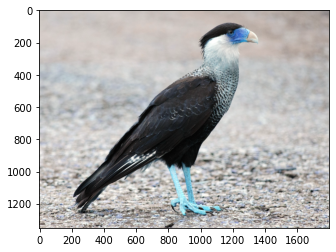

2022-05-08 19:38:34.094632: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


CRESTED CARACARA with 100.0% confidence


In [13]:
import tensorflow as tf

model = tf.keras.models.load_model('./models/mobile_net.h5')

predict_image_path = './dataset/images to test/20.jpg'

plt.imshow(cv2.imread(predict_image_path))
plt.show();

img = load_img(predict_image_path, target_size=(224,224))
img = img_to_array(img)
img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
img = preprocess_input(img)

predictions = model.predict(img)
label, confidence = decode(predictions)

print(label + ' with ' + str(confidence) + '% confidence')

# Resources

Architectures images from [Deep Learning for Vision Systems Book](https://www.manning.com/books/deep-learning-for-vision-systems)